In [2]:
import os
import glob

import cv2
import numpy as np

import torch
from torchvision.transforms.functional import normalize
from gfpgan.archs.gfpganv1_arch import GFPGANv1
from basicsr.utils import img2tensor, tensor2img

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
gfpgan = GFPGANv1(
    out_size=512,
    num_style_feat=512,
    channel_multiplier=1,
    decoder_load_path=None,
    fix_decoder=True,
    num_mlp=8,
    input_is_latent=True,
    different_w=True,
    narrow=1,
    sft_half=True)

In [3]:
gfpgan

GFPGANv1(
  (conv_body_first): ConvLayer(
    (0): EqualConv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0, bias=False)
    (1): FusedLeakyReLU()
  )
  (conv_body_down): ModuleList(
    (0): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        (1): FusedLeakyReLU()
      )
      (conv2): ConvLayer(
        (0): UpFirDnSmooth(upsample_factor=1, downsample_factor=2)
        (1): EqualConv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0, bias=False)
        (2): FusedLeakyReLU()
      )
      (skip): ConvLayer(
        (0): UpFirDnSmooth(upsample_factor=1, downsample_factor=2)
        (1): EqualConv2d(in_channels=16, out_channels=32, kernel_size=1, stride=2, padding=0, bias=False)
      )
    )
    (1): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
      

In [23]:
loadnet = torch.load('/home/viu/Work/GFPGAN/experiments/train_GFPGANv1_512_simple/models/net_g_70000.pth')
if 'params_ema' in loadnet:
    keyname = 'params_ema'
else:
    keyname = 'params'
gfpgan.load_state_dict(loadnet[keyname], strict=True)
gfpgan.eval()
gfpgan = gfpgan.to('cuda:0')

In [24]:
from facexlib.utils.face_restoration_helper import FaceRestoreHelper

face_helper = FaceRestoreHelper(
    2,
    face_size=512,
    crop_ratio=(1, 1),
    det_model='retinaface_resnet50',
    save_ext='png',
    device='cuda:0'
)

In [4]:
tub_faces = glob.glob('/data/datasets/real_tubface_99/frames/PC00C00_R1_frames/*.png')
tub_faces[256]

'/data/datasets/real_tubface_99/frames/PC00C00_R1_frames/Victorem_0213__None_PC00C00__R1_000_1-180915-093447_0.png'

In [26]:
idx = 256
tub_face_img = cv2.imread(tub_faces[idx], cv2.IMREAD_COLOR)
face_helper.clean_all()
face_helper.read_image(tub_face_img)
face_helper.get_face_landmarks_5(only_center_face=True)
face_helper.align_warp_face()
tub_face_img = face_helper.cropped_faces[0]

tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')

In [27]:
output = gfpgan(tub_face_img_th, return_rgb=False)[0]
restored_face_img = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1))

restored_face_img_compare = np.concatenate([tub_face_img, restored_face_img], axis=1)

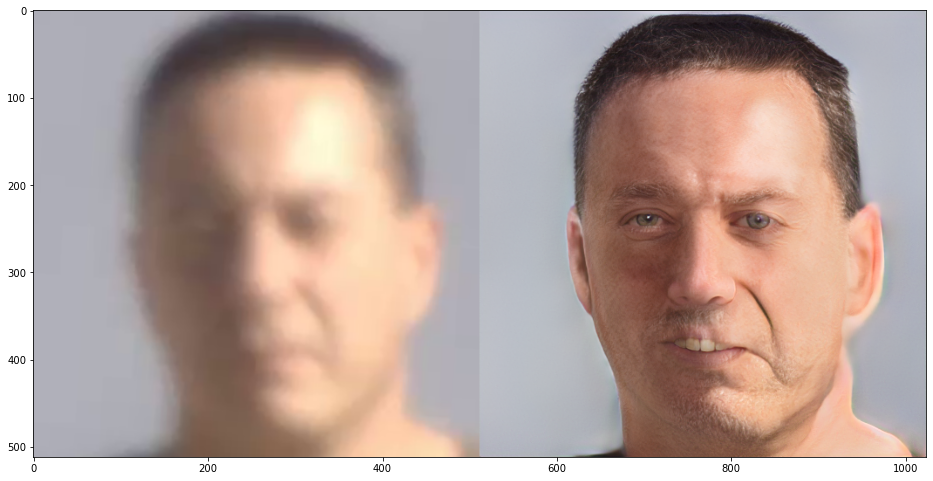

In [28]:
plt.figure(figsize=(16, 16))
plt.imshow(restored_face_img_compare[:, :, ::-1])
plt.savefig('./now.png')

In [ ]:
for tub_face in tqdm(tub_faces):
    tub_face_img = cv2.imread(tub_face, cv2.IMREAD_COLOR)
    face_helper.clean_all()
    face_helper.read_image(tub_face_img)
    face_helper.get_face_landmarks_5(only_center_face=True)
    face_helper.align_warp_face()
    if len(face_helper.cropped_faces) < 1:
        print(tub_face)
        break
    tub_face_img = face_helper.cropped_faces[0]

    tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
    normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')
    output = gfpgan(tub_face_img_th, return_rgb=False)[0]
    restored_face_img = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1))

    restored_face_img_compare = np.concatenate([tub_face_img, restored_face_img], axis=1)
    cv2.imwrite(os.path.join('/data/datasets/real_tubface_99/frames/RESULTS/PC00C00_R1_frames_GFPGAN_exp', os.path.basename(tub_face)), restored_face_img_compare)
    # cv2.imwrite(os.path.join('/data/datasets/real_tubface_99/frames/PC00C00_R1_frame_faces', os.path.basename(tub_face)), tub_face_img)


In [1]:
import torch
from gfpgan.archs.gfpganswin_arch import GFPGANSWIN

In [2]:
gfpgan = GFPGANSWIN(
    out_size=512,
    num_style_feat=512,
    channel_multiplier=1,
    decoder_load_path=None,
    fix_decoder=True,
    num_mlp=8,
    input_is_latent=True,
    different_w=True,
    narrow=1,
    sft_half=True)
gfpgan = gfpgan.to('cuda:0')

In [3]:
output = gfpgan(torch.rand((1, 3, 512, 512)).cuda(0))[0]

In [5]:
output.shape

torch.Size([1, 3, 512, 512])